# MATRIXS REQUIRED TO DISPLAY

1. Each and every model with hyperparameter tuning (learning rate).

2. Validation loss curve, Training loss curve, Validation accuracy curve

3. Model training performance matrices (precision, recall, and F1 score)

4. Model testing performance matrices (precision, recall, and F1 score)

5. Number of epochs model trained on.

6. Dataset Before and After Augmentation.

7. Testing Confusion matrix.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [3]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/MerakiNexus-V2.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.14).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'MerakiNexus-V2'...
remote: Enumerating objects: 6501, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 6501 (delta 3), reused 8 (delta 2), pack-reused 6479 (from 2)
Receiving objects: 100% (6501/6501), 1.92 GiB | 17.40 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Updating files: 100% (6235/6235), done.


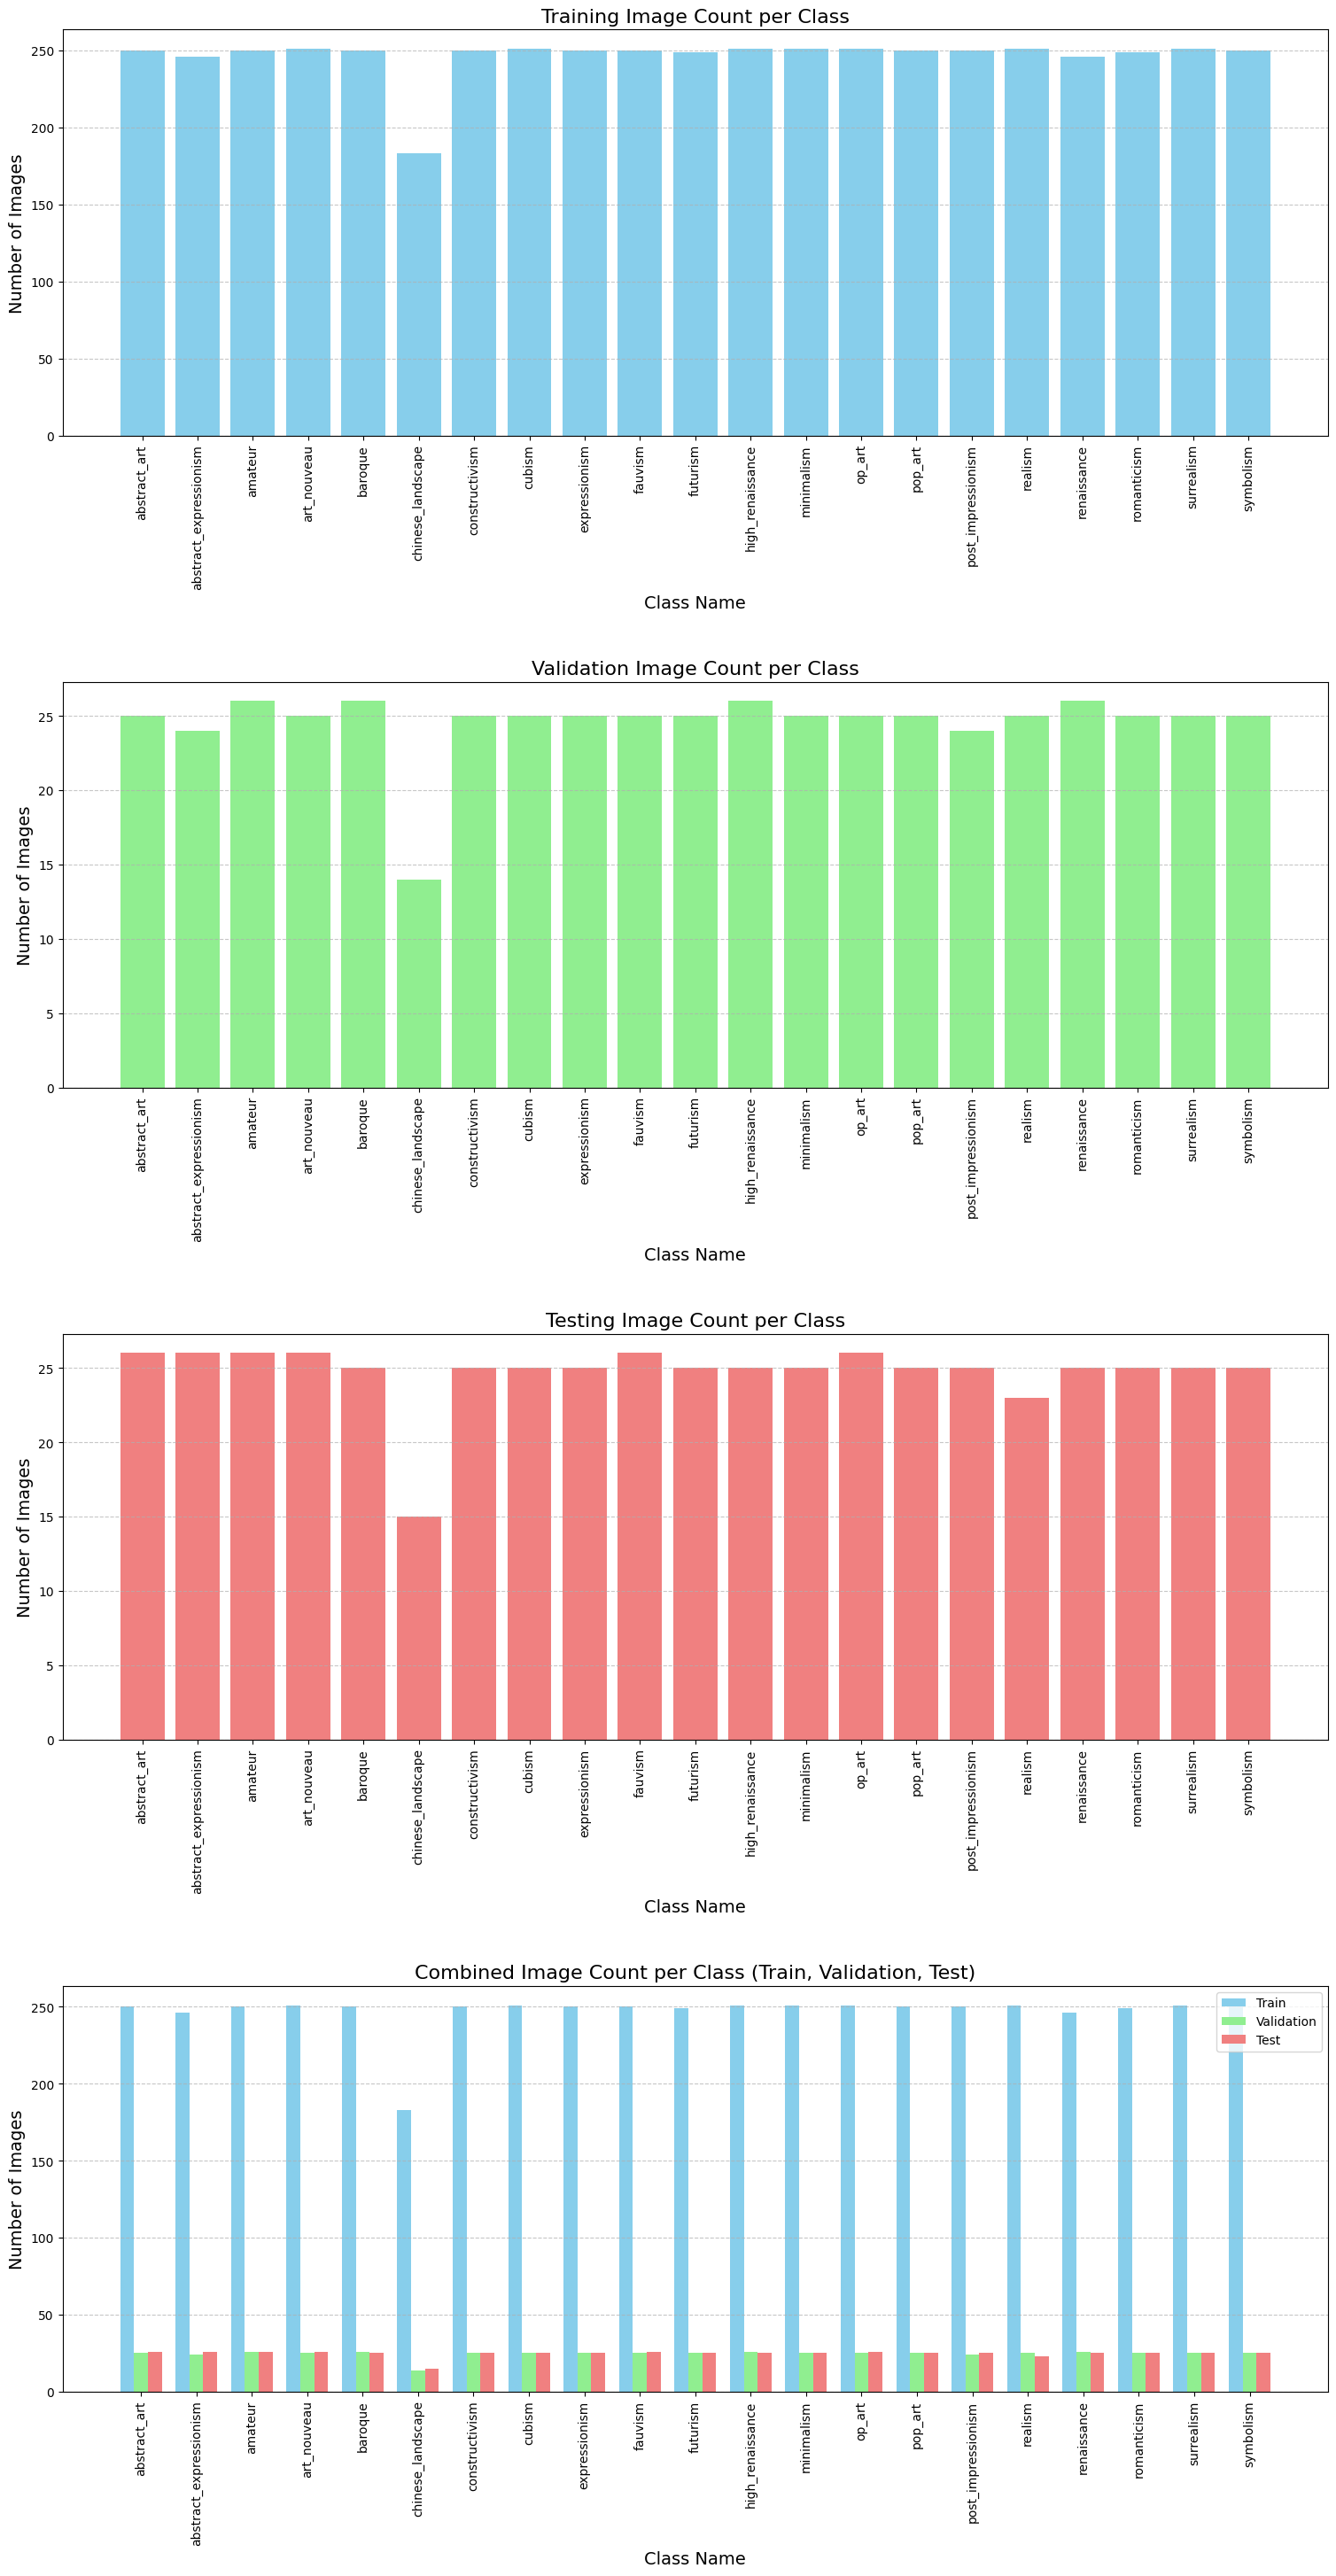

In [4]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"  # Update path if needed

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and initialize counters
class_names = train_dataset.classes
train_image_counts, val_image_counts, test_image_counts = [], [], []

# Count images per class
for class_name in class_names:
    train_count = len(os.listdir(os.path.join(train_dataset.root, class_name)))
    val_count = len(os.listdir(os.path.join(val_dataset.root, class_name)))
    test_count = len(os.listdir(os.path.join(test_dataset.root, class_name)))

    train_image_counts.append(train_count)
    val_image_counts.append(val_count)
    test_image_counts.append(test_count)

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 30))  # Wider + taller for readability

# Common x-axis style
def style_x_axis(ax):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, fontsize=10)
    ax.set_xlabel("Class Name", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Training set plot
axes[0].bar(range(len(class_names)), train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
style_x_axis(axes[0])

# Validation set plot
axes[1].bar(range(len(class_names)), val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
style_x_axis(axes[1])

# Test set plot
axes[2].bar(range(len(class_names)), test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
style_x_axis(axes[2])

# Combined view with grouped bars
bar_width = 0.25
x = list(range(len(class_names)))

axes[3].bar([i - bar_width for i in x], train_image_counts, width=bar_width, label='Train', color='skyblue')
axes[3].bar(x, val_image_counts, width=bar_width, label='Validation', color='lightgreen')
axes[3].bar([i + bar_width for i in x], test_image_counts, width=bar_width, label='Test', color='lightcoral')

axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xticks(x)
axes[3].set_xticklabels(class_names, rotation=90, fontsize=10)
axes[3].set_xlabel("Class Name", fontsize=14)
axes[3].set_ylabel("Number of Images", fontsize=14)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout(pad=4)
plt.show()


| **Hyperparameter**           | **Value**                                                      |
| ---------------------------- | -------------------------------------------------------------- |
| Model Architecture           | Vision Transformer (ViT-B/16) - `vit_b_16`                     |
| Pretrained Weights           | ImageNet-21k                                                   |
| Input Image Size             | 224 × 224                                                      |
| Patch Size                   | 16 × 16                                                        |
| Embedding Dimension          | 768                                                            |
| Number of Attention Heads    | 12                                                             |
| Number of Transformer Layers | 12                                                             |
| Batch Size                   | 32                                                             |
| Number of Epochs             | 25                                                             |
| Learning Rate                | 0.0001 (1e-4)                                                  |
| Optimizer                    | Adam                                                           |
| Weight Decay                 | 0.00001 (1e-5)                                                 |
| Loss Function                | CrossEntropyLoss                                               |
| Dropout (Custom Head)        | 0.5 before first Linear, 0.3 before final layer                |
| Data Augmentation            | Resize, RandomHorizontalFlip, RandomRotation(10°), ColorJitter |
| Normalization (mean/std)     | Mean: \[0.485, 0.456, 0.406], Std: \[0.229, 0.224, 0.225]      |
| Layers Fine-Tuned            | Final encoder normalization + classification head              |
| Device                       | CUDA (GPU) if available, otherwise CPU                         |
| Evaluation Metrics           | Accuracy, Precision, Recall, F1-Score, Confusion Matrix        |


Train samples: 5168 | Val samples: 512 | Test samples: 511


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 86.1MB/s]



Starting Training...



Epoch 1/25 Training: 100%|██████████| 162/162 [01:56<00:00,  1.39it/s, loss=2.15]


Epoch 1 Completed | Train Loss: 2.8040 | Val Loss: 2.3603 | Val Acc: 32.23% | Time: 127.35s


Epoch 2/25 Training: 100%|██████████| 162/162 [01:59<00:00,  1.36it/s, loss=2.04]


Epoch 2 Completed | Train Loss: 2.1948 | Val Loss: 2.0382 | Val Acc: 38.48% | Time: 129.08s


Epoch 3/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.37it/s, loss=2.32]


Epoch 3 Completed | Train Loss: 1.9089 | Val Loss: 1.8872 | Val Acc: 43.55% | Time: 128.84s


Epoch 4/25 Training: 100%|██████████| 162/162 [01:59<00:00,  1.36it/s, loss=1.85]


Epoch 4 Completed | Train Loss: 1.7428 | Val Loss: 1.7753 | Val Acc: 45.51% | Time: 129.48s


Epoch 5/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=1.04]


Epoch 5 Completed | Train Loss: 1.6127 | Val Loss: 1.6879 | Val Acc: 49.02% | Time: 129.17s


Epoch 6/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.37it/s, loss=1.2]


Epoch 6 Completed | Train Loss: 1.5343 | Val Loss: 1.6632 | Val Acc: 48.24% | Time: 128.98s


Epoch 7/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=1.83]


Epoch 7 Completed | Train Loss: 1.4479 | Val Loss: 1.6044 | Val Acc: 50.20% | Time: 129.43s


Epoch 8/25 Training: 100%|██████████| 162/162 [01:59<00:00,  1.36it/s, loss=1.17]


Epoch 8 Completed | Train Loss: 1.3948 | Val Loss: 1.5724 | Val Acc: 50.98% | Time: 129.89s


Epoch 9/25 Training: 100%|██████████| 162/162 [01:59<00:00,  1.36it/s, loss=0.999]


Epoch 9 Completed | Train Loss: 1.3566 | Val Loss: 1.5534 | Val Acc: 49.61% | Time: 129.85s


Epoch 10/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=0.921]


Epoch 10 Completed | Train Loss: 1.2891 | Val Loss: 1.5378 | Val Acc: 52.15% | Time: 129.51s


Epoch 11/25 Training: 100%|██████████| 162/162 [01:57<00:00,  1.37it/s, loss=1.45]


Epoch 11 Completed | Train Loss: 1.2596 | Val Loss: 1.5000 | Val Acc: 51.76% | Time: 128.28s


Epoch 12/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=0.874]


Epoch 12 Completed | Train Loss: 1.2382 | Val Loss: 1.4668 | Val Acc: 55.27% | Time: 129.09s


Epoch 13/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.37it/s, loss=0.829]


Epoch 13 Completed | Train Loss: 1.1987 | Val Loss: 1.4893 | Val Acc: 53.91% | Time: 128.62s


Epoch 14/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=1.39]


Epoch 14 Completed | Train Loss: 1.1877 | Val Loss: 1.4783 | Val Acc: 53.12% | Time: 129.53s


Epoch 15/25 Training: 100%|██████████| 162/162 [01:59<00:00,  1.36it/s, loss=1.55]


Epoch 15 Completed | Train Loss: 1.1604 | Val Loss: 1.4259 | Val Acc: 56.84% | Time: 128.96s


Epoch 16/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=1.34]


Epoch 16 Completed | Train Loss: 1.1340 | Val Loss: 1.4150 | Val Acc: 56.45% | Time: 129.31s


Epoch 17/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=0.908]


Epoch 17 Completed | Train Loss: 1.1218 | Val Loss: 1.4210 | Val Acc: 56.05% | Time: 128.92s


Epoch 18/25 Training: 100%|██████████| 162/162 [01:59<00:00,  1.36it/s, loss=0.942]


Epoch 18 Completed | Train Loss: 1.0789 | Val Loss: 1.4252 | Val Acc: 55.08% | Time: 129.58s


Epoch 19/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=1.01]


Epoch 19 Completed | Train Loss: 1.0904 | Val Loss: 1.3647 | Val Acc: 56.45% | Time: 129.08s


Epoch 20/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.37it/s, loss=1.19]


Epoch 20 Completed | Train Loss: 1.0798 | Val Loss: 1.3965 | Val Acc: 57.03% | Time: 128.75s


Epoch 21/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.36it/s, loss=0.72]


Epoch 21 Completed | Train Loss: 1.0386 | Val Loss: 1.4159 | Val Acc: 56.84% | Time: 129.20s


Epoch 22/25 Training: 100%|██████████| 162/162 [01:57<00:00,  1.37it/s, loss=1.23]


Epoch 22 Completed | Train Loss: 1.0388 | Val Loss: 1.3653 | Val Acc: 57.23% | Time: 128.48s


Epoch 23/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.37it/s, loss=1.34]


Epoch 23 Completed | Train Loss: 1.0147 | Val Loss: 1.3612 | Val Acc: 56.84% | Time: 128.87s


Epoch 24/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.37it/s, loss=1.05]


Epoch 24 Completed | Train Loss: 1.0198 | Val Loss: 1.3629 | Val Acc: 54.30% | Time: 128.26s


Epoch 25/25 Training: 100%|██████████| 162/162 [01:58<00:00,  1.37it/s, loss=2.23]


Epoch 25 Completed | Train Loss: 0.9882 | Val Loss: 1.3771 | Val Acc: 55.66% | Time: 128.94s

Total Training Time: 3225.46s (53.76 minutes)


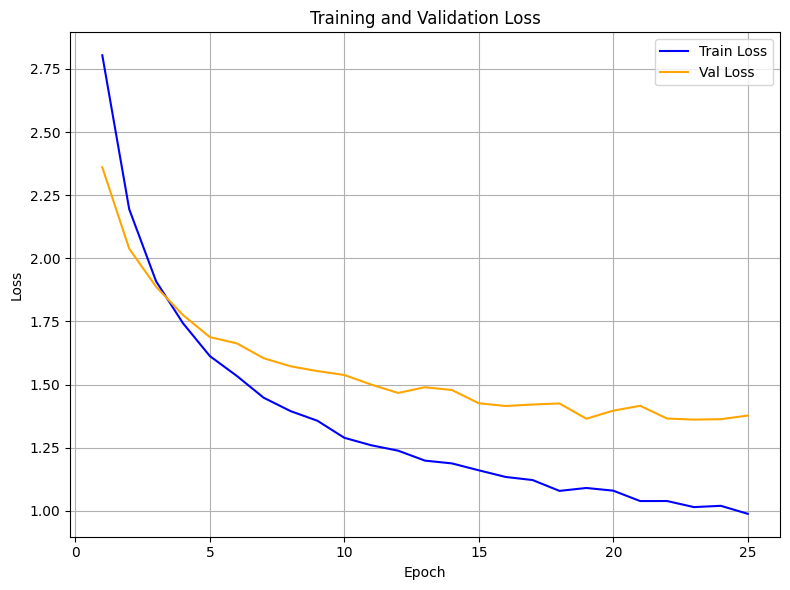

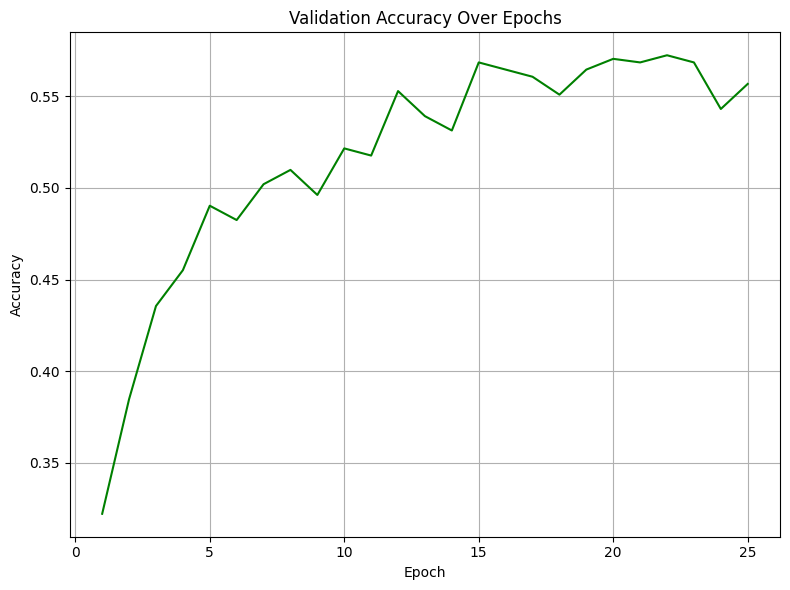

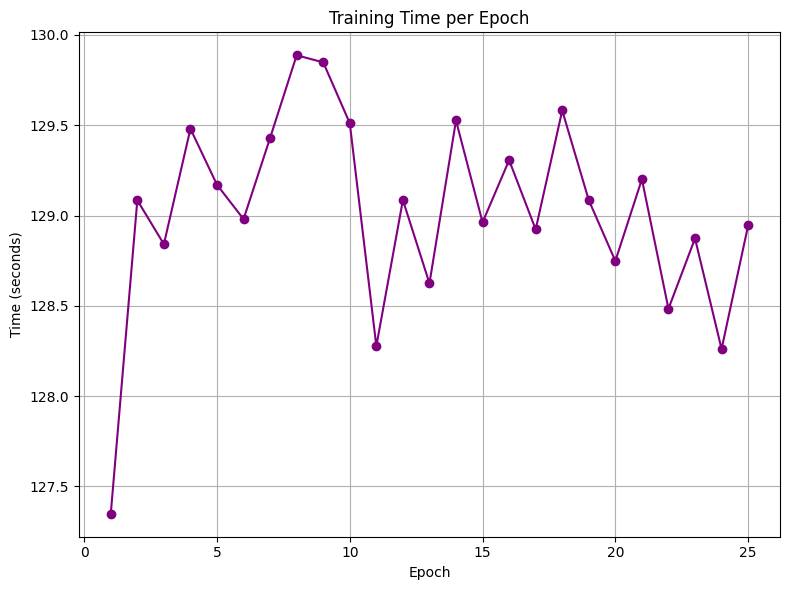


Test Accuracy: 58.32%

Precision, Recall, F1-Score Table:

                        precision  recall  f1-score
abstract_art                0.600   0.360     0.450
abstract_expressionism      0.520   0.520     0.520
amateur                     0.579   0.440     0.500
art_nouveau                 0.571   0.320     0.410
baroque                     0.826   0.792     0.809
chinese_landscape           0.478   0.786     0.595
constructivism              0.722   0.520     0.605
cubism                      0.700   0.280     0.400
expressionism               0.438   0.560     0.491
fauvism                     0.286   0.480     0.358
futurism                    0.588   0.400     0.476
high_renaissance            0.739   0.680     0.708
minimalism                  0.759   0.880     0.815
op_art                      0.667   0.800     0.727
pop_art                     0.533   0.640     0.582
post_impressionism          0.538   0.560     0.549
realism                     0.696   0.696     0.696
rena

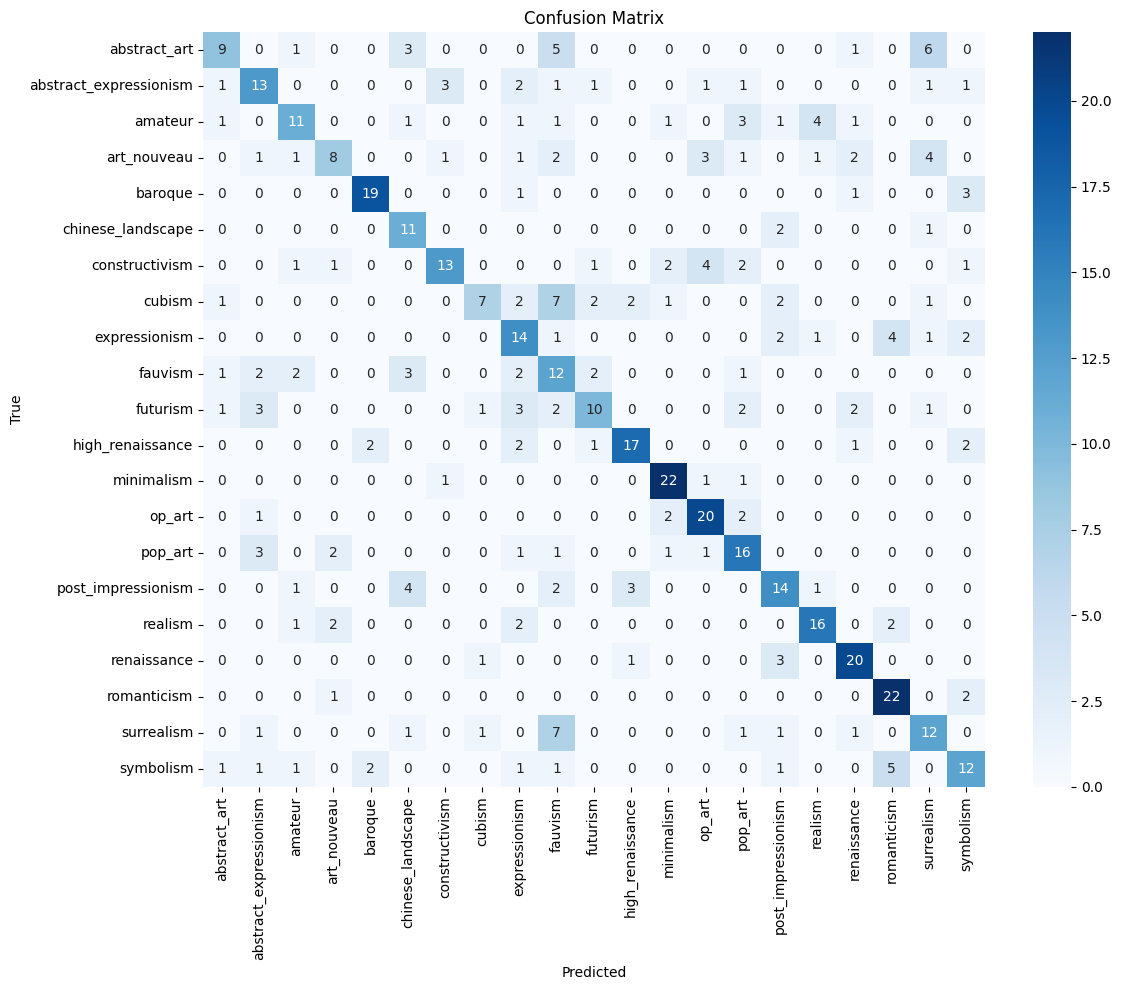

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import pandas as pd
import time

# ======== Device Configuration ========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== Data Transforms (ViT input: 224x224) ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======== Dataset and DataLoaders ========
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_data = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_data = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# ======== Vision Transformer Model Definition ========
class ArtworkClassificationViT(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationViT, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)

        # Freeze all parameters
        for param in self.vit.parameters():
            param.requires_grad = False

        # Unfreeze last block and classification head
        for param in self.vit.encoder.ln.parameters():
            param.requires_grad = True
        for param in self.vit.heads.parameters():
            param.requires_grad = True

        # Replace classification head
        hidden_dim = self.vit.heads.head.in_features
        self.vit.heads = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.vit(x)

model = ArtworkClassificationViT(num_classes=len(train_data.classes)).to(device)

# ======== Loss Function and Optimizer ========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

# ======== Training Loop ========
num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []
epoch_times = []

print("\nStarting Training...\n")
for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_loss_epoch = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss_epoch)

    # ======== Validation ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_accuracy)

    epoch_duration = time.time() - epoch_start
    epoch_times.append(epoch_duration)

    print(f"Epoch {epoch+1} Completed | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_accuracy*100:.2f}% | Time: {epoch_duration:.2f}s")

total_training_time = sum(epoch_times)
print(f"\nTotal Training Time: {total_training_time:.2f}s ({total_training_time/60:.2f} minutes)")

# ======== Plotting ========

# Training & Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss", color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy", color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Time Per Epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), epoch_times, marker='o', color='purple')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Evaluation on Test Set ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# ======== Classification Report & Confusion Matrix ========
report = classification_report(all_labels, all_preds, target_names=train_data.classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\nPrecision, Recall, F1-Score Table:\n")
print(df_report[['precision', 'recall', 'f1-score']].round(3))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [6]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/artwork_classification_model_subject_2_VIT.pth");


✅ Test Accuracy: 59.69%

📊 Classification Report (per class):

                        precision  recall  f1-score
abstract_art                0.583   0.280     0.378
abstract_expressionism      0.565   0.520     0.542
amateur                     0.737   0.560     0.636
art_nouveau                 0.444   0.320     0.372
baroque                     0.692   0.750     0.720
chinese_landscape           0.565   0.929     0.703
constructivism              0.667   0.480     0.558
cubism                      0.818   0.360     0.500
expressionism               0.433   0.520     0.473
fauvism                     0.325   0.520     0.400
futurism                    0.682   0.600     0.638
high_renaissance            0.895   0.680     0.773
minimalism                  0.792   0.760     0.776
op_art                      0.594   0.760     0.667
pop_art                     0.704   0.760     0.731
post_impressionism          0.560   0.560     0.560
realism                     0.583   0.609     0.596


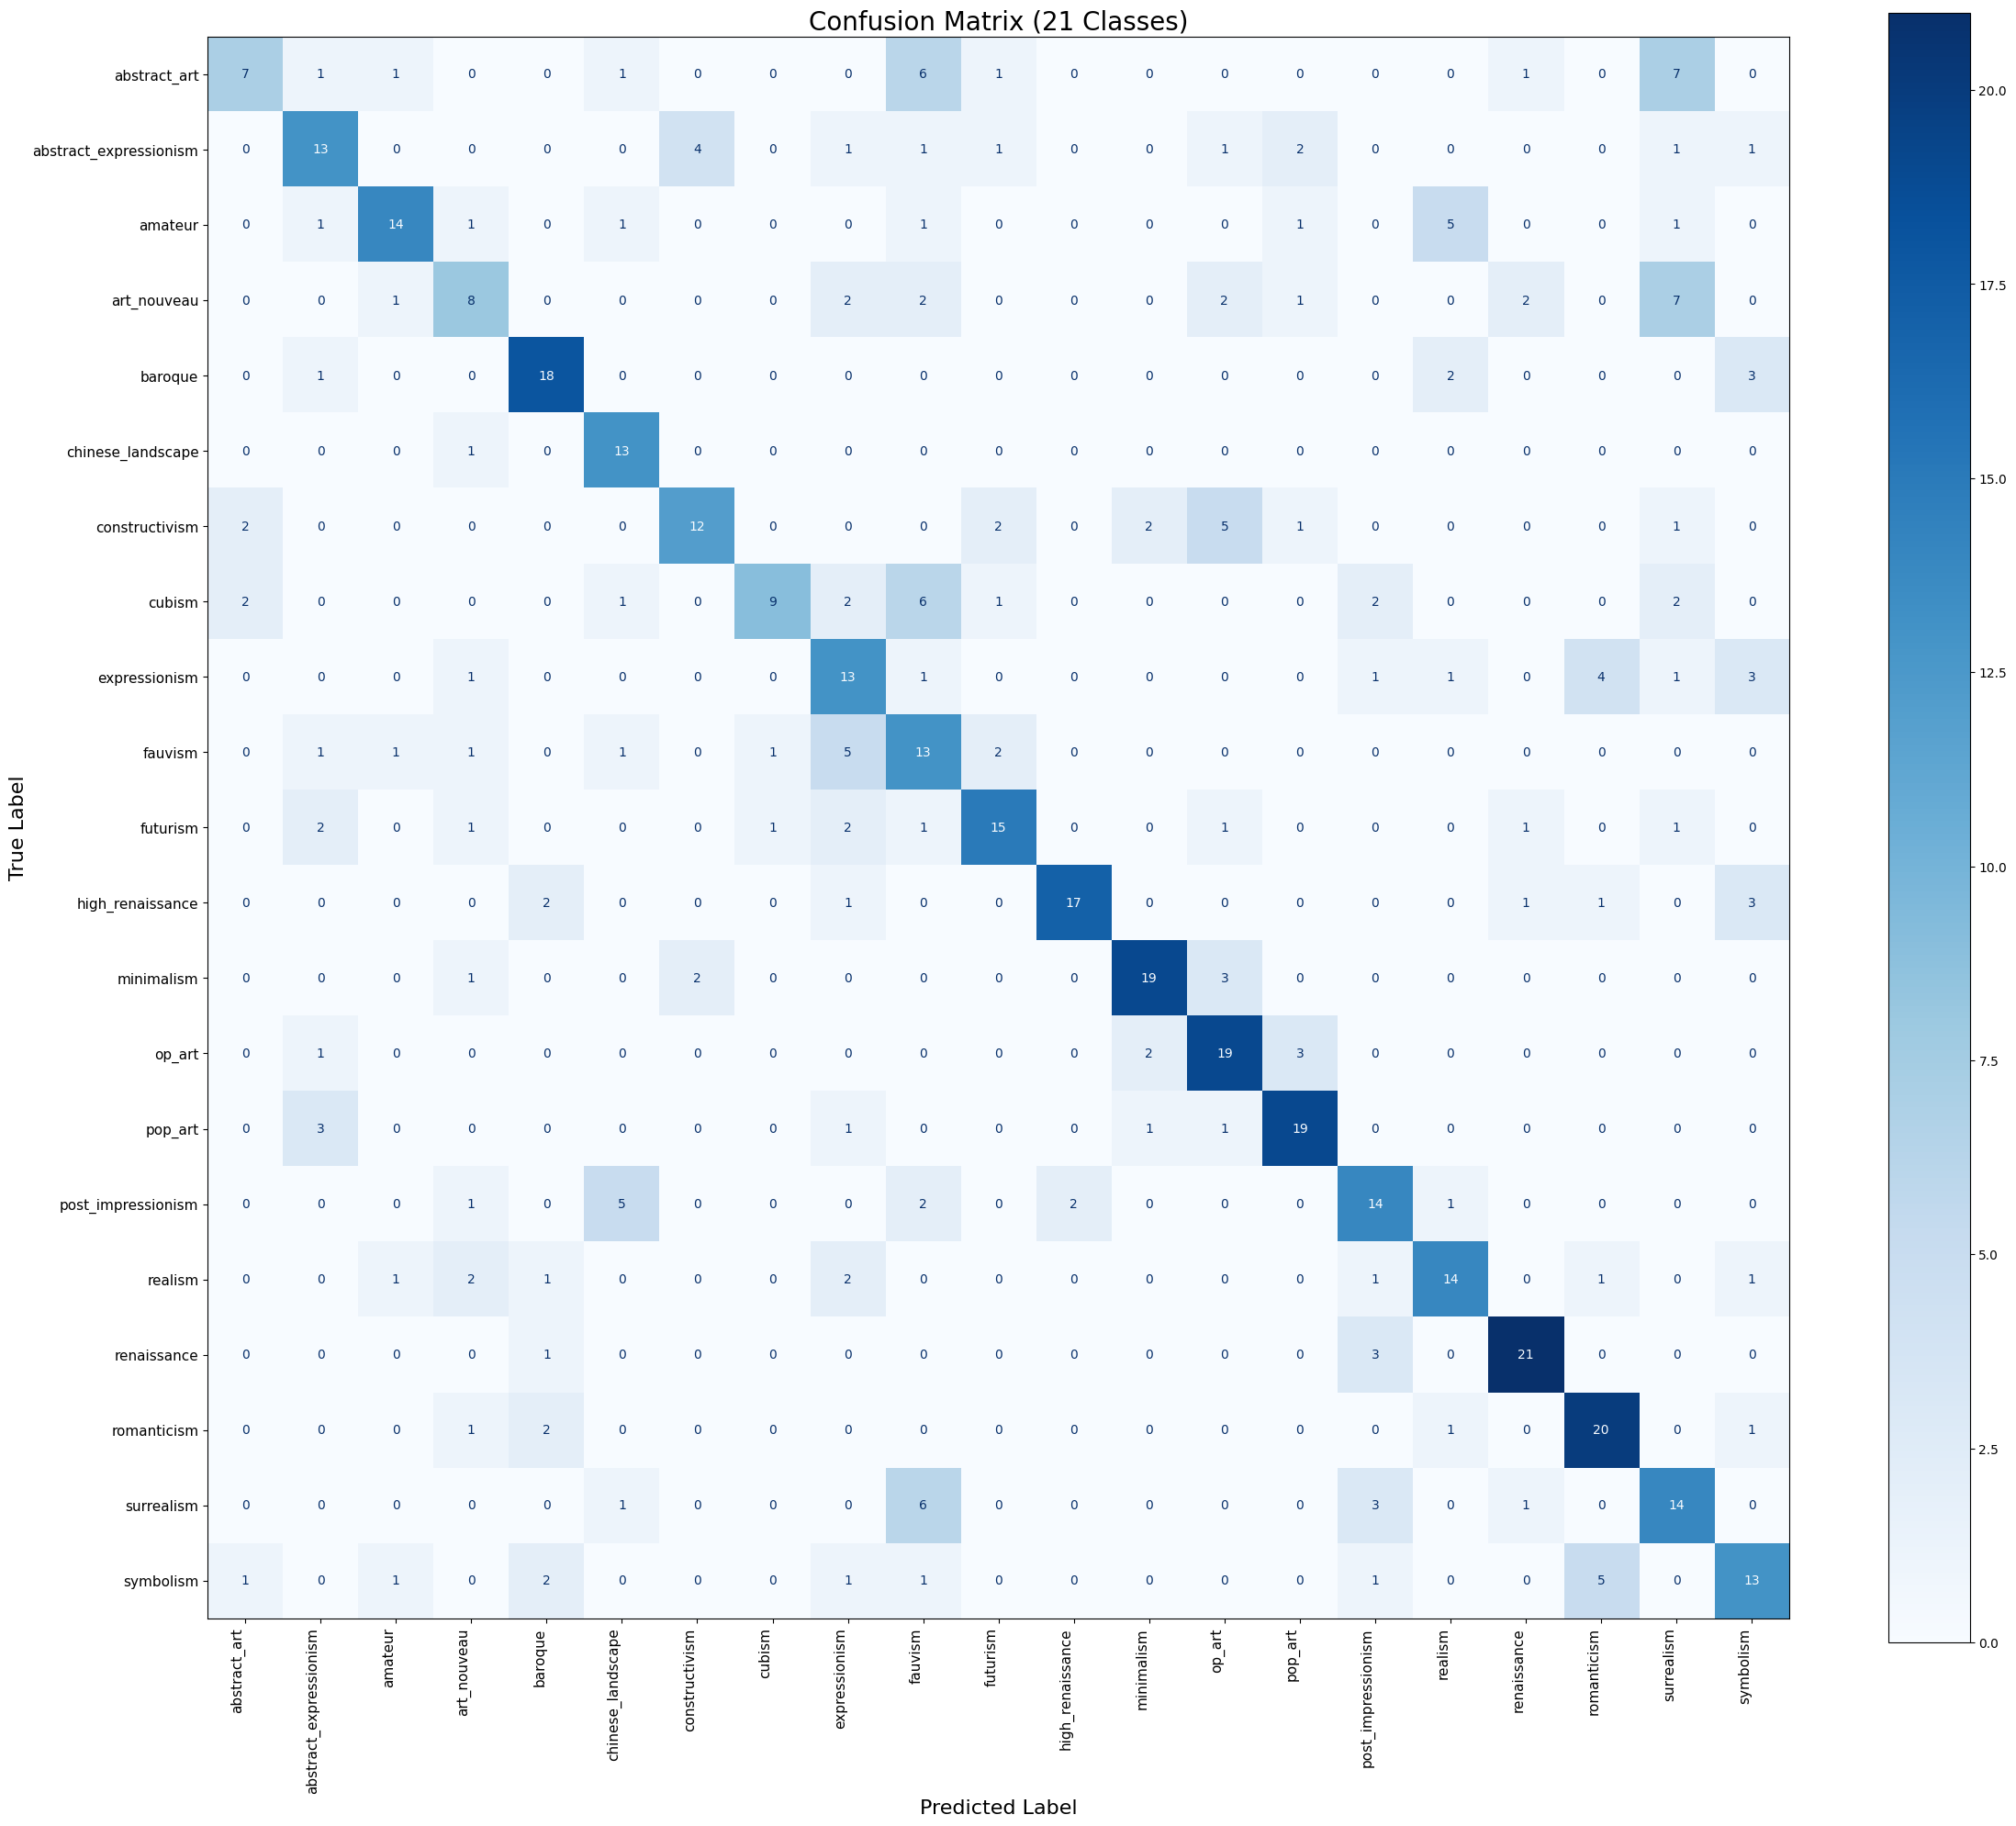

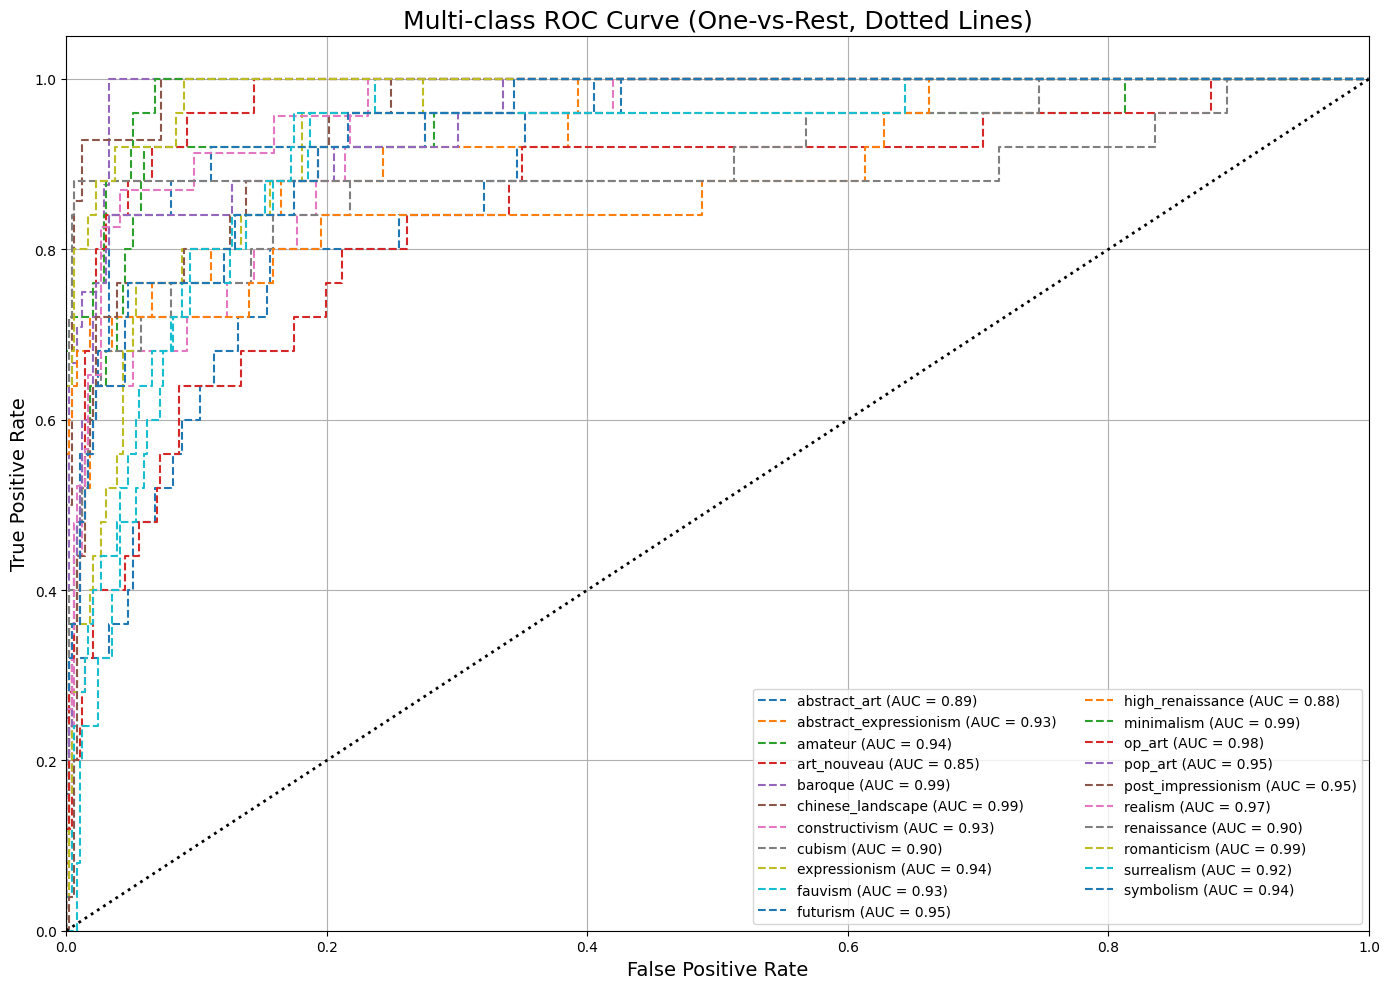

In [7]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# ========== Define transforms ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== Load the test dataset ==========
test_dataset = datasets.ImageFolder(
    '/content/MerakiNexus-V2/art_classification_model/dataset/test',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ========== Load TorchScript model ==========
scripted_model = torch.jit.load("/content/artwork_classification_model_subject_2_VIT.pth")
scripted_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model.to(device)

# ========== Evaluation on Test Set ==========
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = scripted_model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ========== Overall Test Accuracy ==========
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# ========== Precision, Recall, F1-Score ==========
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=3,
    output_dict=True
)
df_metrics = pd.DataFrame(report).transpose()
print("\n📊 Classification Report (per class):\n")
print(df_metrics[['precision', 'recall', 'f1-score']].round(3))

# Optional: Save report as CSV
# df_metrics.to_csv("classification_metrics_test.csv")

# ========== Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(24, 20))
disp.plot(
    cmap="Blues",
    values_format='d',
    ax=ax
)

plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=11)
plt.setp(ax.get_yticklabels(), fontsize=11)
ax.set_title("Confusion Matrix (21 Classes)", fontsize=20)
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)
plt.tight_layout()
plt.show()

# ========== ROC Curve ==========
# Binarize labels
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class as dotted lines
plt.figure(figsize=(14, 10))
for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        linestyle='--',
        lw=1.5,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k:', lw=2)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-class ROC Curve (One-vs-Rest, Dotted Lines)", fontsize=18)
plt.legend(loc="lower right", fontsize=10, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
